In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

plt.rcParams.update({"font.size": 13})

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, ``x``,  of `len(N)` (with $N = O(100)$) with a normally distributed variable, with a given mean and standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper $y$ axis label
   * set a proper value for the $y$ axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of $x$, create a gaussian with the mean corresponding to the element value and `std` as a parameter that can be tuned. The `std` default value should be:
    ```python
    1.06 * x.std() * x.size**(-1 / 5)
    ```
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Text(0, 0.5, '$\\mathcal{N}(x)$')

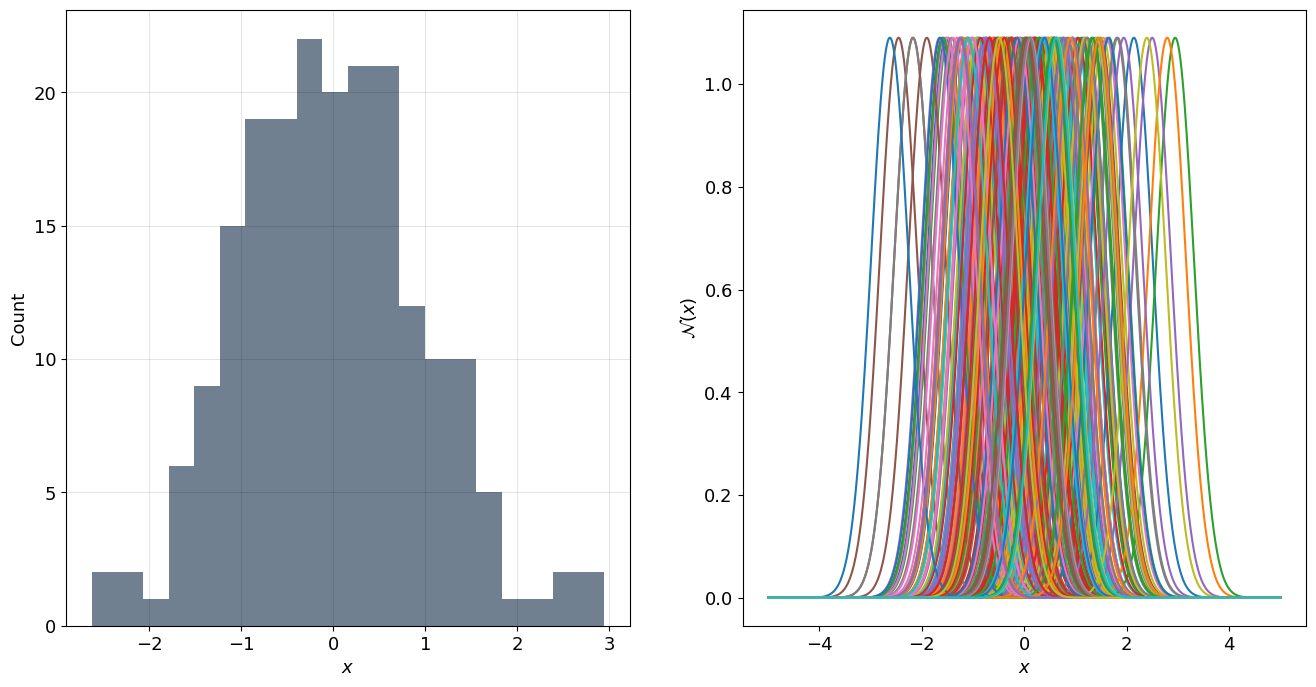

In [2]:
N = 200
mu = 0
sigma = 1

# generate N normally distributed numbers
data = np.random.normal(mu, sigma, N)
# set standard deviation for the gaussians later on
std = 1.06 * data.std() * N**(-1 / 5)

domain = np.linspace(-5 * sigma, 5 * sigma, 1000)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# histogram plot (bins variable is needed later)
counts, bins, _ = ax1.hist(data, 20, facecolor="#708090")
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel("Count")
ax1.grid(visible=True, color="k", alpha=0.1)

# gaussians plot
for avg in data:
    ax2.plot(domain, sp.stats.norm.pdf(domain, avg, std))
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$\mathcal{N}(x)$")

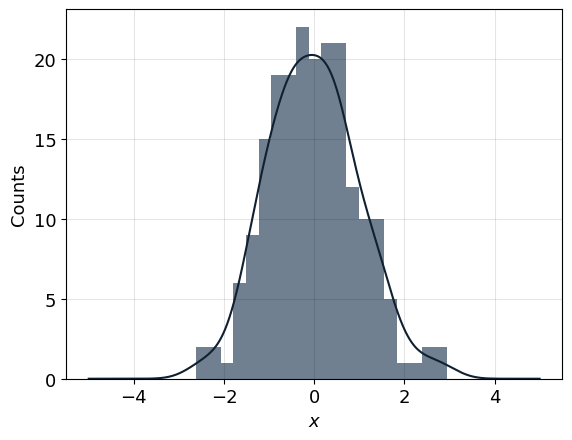

In [3]:
# sum the gaussians
gaussians = np.array([sp.stats.norm.pdf(domain, avg, std) for avg in data])
gauss_sum = np.sum(gaussians, axis=0)

# recover binning data from before
bin_means = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)]
hist_integral = sp.integrate.trapz(counts, bin_means)

# renormalize gaussian
gauss_integral = sp.integrate.trapz(gauss_sum, domain)
gauss_sum *= hist_integral / gauss_integral

plt.stairs(counts, bins, color="#708090", fill=True)
plt.plot(domain, gauss_sum, color="#102030")
plt.xlabel(r"$x$")
plt.ylabel("Counts")
plt.grid(True, color="k", alpha=0.1)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [77]:
def dataset_2d(num_1, mean_1, cov_1, num_2, mean_2, cov_2):
    data_1 = np.random.multivariate_normal(mean_1, cov_1, num_1)
    data_1 = pd.DataFrame(
        {
            "x": data_1[:, 0],
            "y": data_1[:, 1],
            "Category": pd.Categorical(['A'] * num_1)
        }
    )

    data_2 = np.random.multivariate_normal(mean_2, cov_2, num_2)
    data_2 = pd.DataFrame(
        {
            "x": data_2[:, 0],
            "y": data_2[:, 1],
            "Category": pd.Categorical(['B'] * num_2)
        }
    )

    return pd.concat([data_1, data_2])

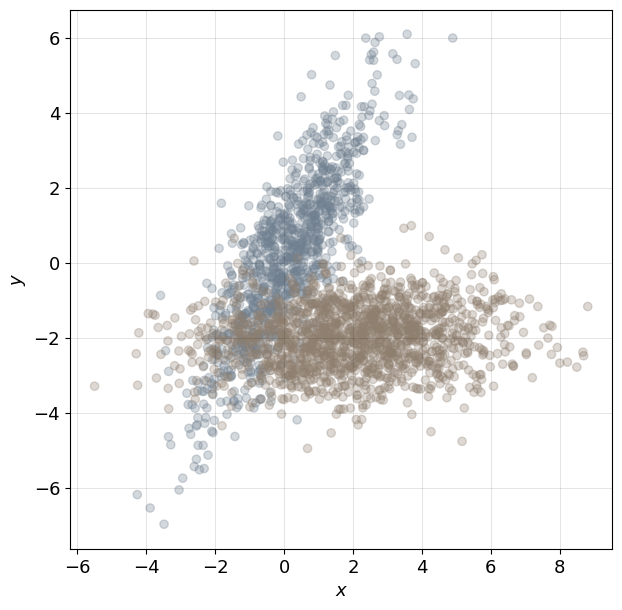

In [97]:
df = dataset_2d(1000, [0, 0], [[1.5, 2], [2, 4]],
                1500, [2, -2], [[5, 0.2], [0.2, 0.7]])

plt.figure(figsize=(7, 7))
color_map = {'A': "#708090", 'B': "#8f7f6f"}
plt.scatter(x=df["x"], y=df["y"],
            color=df["Category"].map(color_map),
            alpha=0.3)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.grid(True, color='k', alpha=0.1)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

In [164]:
df = pd.DataFrame(np.load("residuals_261.npy", allow_pickle=True).item())
# filter out entries with residuals > 2 in abs value
# also, weâ€™ll keep only every 10th entry, to have less data points
df = df[np.abs(df["residuals"]) < 2].iloc[::20]

# linear regression with scipy
reg = sp.stats.linregress(x=df["distances"], y=df["residuals"])
print("Linear regression results:")
print(f"Slope: {reg.slope:.5f}")
print(f"Intercept: {reg.intercept:.5f}")
print(f"R-squared: {reg.rvalue:.5f}")

Linear regression results:
Slope: 0.00251
Intercept: -0.14078
R-squared: 0.03220


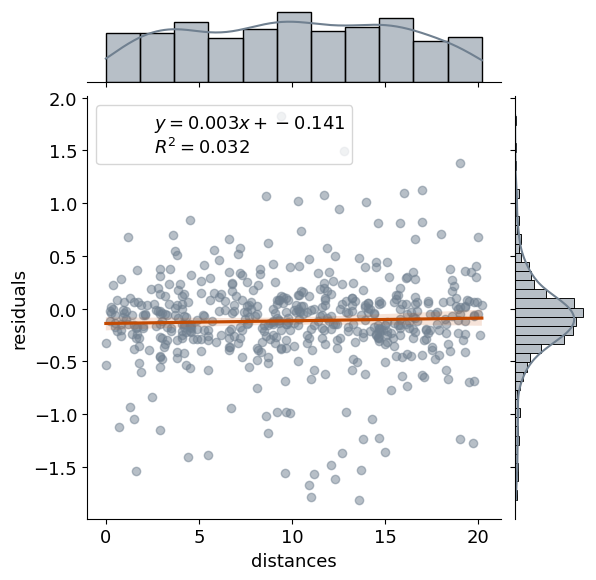

In [168]:
jp = sns.jointplot(data=df, x="distances", y="residuals", kind='reg',
                   color="#708090",
                   joint_kws=dict(scatter_kws=dict(alpha=0.5),
                                  line_kws=dict(color='#C44900')))

# workaround to get legend from stackoverflow
axis, = jp.ax_joint.plot([], [], linestyle='', alpha=0)
jp.ax_joint.legend([axis],
                   [rf"$y = {reg.slope:.3f}x + {reg.intercept:.3f}$"
                    + '\n' + rf"$R^2 = {reg.rvalue:.3f}$"])